In [1]:
import geopandas as gpd
import pandas as pd

dfde = gpd.read_parquet('../data/processed_datasets/simplified_refined_DFDE_1984_2021_EPSG2154_FR.parquet') #ok 
hm = gpd.read_parquet('../data/processed_datasets/simplified_health-monitoring_2007-2023_EPSG2154_FR.parquet') #ok 
nfi = gpd.read_parquet('../data/processed_datasets/simplified_NFI_2003-2021_EPSG2154_FR.parquet') #ok 
senfseidl = gpd.read_parquet("../data/processed_datasets/simplified_SenfSeidl_joined_EPSG2154_FR.parquet") #ok 
bdiff = gpd.read_parquet('../data/processed_datasets/simplified_bdiff_2012_2022_FR_EPSG2154.parquet') #ok 
cdi = gpd.read_parquet('../data/processed_datasets/simplified_CDI_2012_2023_EPSG2154_FR.parquet') #ajouter tree-specie
forms = gpd.read_parquet('../data/processed_datasets/simplified_FORMS_clearcut_2017_2020_EPSG2154.parquet') #ok


#preprocessing bdiff:
bdiff['class'] = 'Fire'
bdiff = bdiff[ bdiff.forest_area_m2 > 5000 ]
#create function that convert column 'start_date' to pd.datetime with the following format : '%Y-%m-%d', 
# if the 'start_date' is just mentionning the time and not the date, use the year column to create a start_date and end_date column as the first and last day of this year
#create this function as 'to_datetime_safe', it takes as input a row of a dataframe
def to_datetime_safe(row):
    try :
        return pd.to_datetime(row['start_date'], format='%Y-%m-%d'), pd.to_datetime(row['start_date'], format='%Y-%m-%d')
    except ValueError:
        return pd.to_datetime(row['year'], format='%Y'), pd.to_datetime(row['year'], format='%Y') + pd.offsets.YearEnd(0)


bdiff[['start_date', 'end_date']] = bdiff.apply(to_datetime_safe, axis=1, result_type='expand')

#preprocessing tcl:
tcl = gpd.read_parquet('../data/processed_datasets/simplified_TreeCoverLoss_2001-2022_EPSG2154_FR.parquet')
tcl['year'] = tcl['year'] + 2000
tcl['class'] = None

#autoreload 
from attribution import Attribution
from constants import DCLASS_SCORE

temporal_buffer = 2 

#subset of datasets
ddataset = {'dfde': dfde, 'hm': hm, 'nfi': nfi, 'senfseidl': senfseidl, 'bdiff': bdiff, 'cdi':cdi, 'forms':forms}
dtypes = {'dfde': 'polygon', 'hm': 'point', 'nfi': 'point', 'senfseidl': 'point', 'bdiff': 'polygon', 'cdi':'polygon', 'forms':'point'}

ddataset_profile = {
    'dfde': {
        'spatial': ('offset_gaussian', {'offset': 150, 'decrease': 5000}), #offset srt( min(area) / pi), k sqrt(median(area) / pi)
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'hm': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 100}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'nfi': {
        'spatial': ('offset_gaussian', {'offset': 600, 'decrease': 25}),
        'temporal': ('step', {'start': 0, 'end': 5 * 365})
    },
    'bdiff': {
        'spatial': ('weighting_function', {'x0': 500, 'k': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 30})
    },
    'senfseidl': {
        'spatial': ('offset_gaussian', {'offset': 30, 'decrease': 5 * 30}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 1.5 * 365})
    },
    'forms': {
        'spatial': ('offset_gaussian', {'offset': 10, 'decrease': 5*10}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'reference': {
        'spatial': ('offset_gaussian', {'offset': 0, 'decrease': 3 * 50}),
        'temporal': ('step', {'start': 0, 'end': 365})
    },
    'cdi': {
        'spatial': ('offset_gaussian', {'offset': 5000, 'decrease': 500}),
        'temporal': ('offset_gaussian', {'offset': 1 * 365, 'decrease': 365})
    },
}

#visible disturbances
ddisturbance_profile = {
    'fire': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'storm': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1.5 * 365})
    },
    'biotic-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 1000}),
        'temporal': ('gaussian', {'mean': 0, 'std': 365})
    },
    'drought-dieback': {
        'spatial': ('gaussian', {'mean': 0, 'std': 2500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 2*365})
    },
    'biotic-mortality': {
        'spatial': ('gaussian', {'mean': 0, 'std': 250}),
        'temporal': ('gaussian', {'mean': 0, 'std': 3*365})
    },
    'anthropogenic': {
        'spatial': ('gaussian', {'mean': 0, 'std': 500}),
        'temporal': ('gaussian', {'mean': 0, 'std': 1 * 365})
    }
}

doa = {'dfde': 1.0, 'hm': 1.0, 'nfi': 1.0, 'senfseidl': .88, 'bdiff': 1.0, 'cdi':.9, 'forms':0.75}
dsbuffer = {'dfde': None, 'hm': 5000, 'nfi': 7000, 'senfseidl': 100, 'bdiff': None, 'cdi':100, 'forms':100}

attribution = Attribution(ddataset, reference=tcl, doa=doa, dtypes=dtypes, 
                          temporal_buffer=temporal_buffer, dsbuffer=dsbuffer, 
                          dclass_score=DCLASS_SCORE, granularity=5, 
                          ddataset_profile=ddataset_profile, ddisturbance_profile=ddisturbance_profile, 
                          start_year=2017)

dataset dfde is of spatial entity type
-> 95% of the areas are below : 4391.95 km2, median : 71.66 km2
dataset bdiff is of spatial entity type
-> 95% of the areas are below : 127.49 km2, median : 27.37 km2
dataset cdi is of spatial entity type
-> 95% of the areas are below : 174.72 km2, median : 25.00 km2


# Define clusters 

In [7]:
#concatenation of all datasets
import geopandas as gpd
list_dataset = [df for name, df in attribution.ddataset.items() if attribution.dtypes_[name] != 'spatial_entity']
list_spatial_entity_dataset = [df for name, df in attribution.ddataset.items() if attribution.dtypes_[name] == 'spatial_entity']

dataset = gpd.GeoDataFrame(pd.concat(list_dataset), geometry='geometry', crs=list_dataset[0].crs)[attribution.mandatory_columns + ['geometry']].reset_index().rename(columns={'index': 'id'})
dataset

,id,start_date,end_date,class,dataset,year,tree_type,essence,geometry
0,26921,2015-01-01,2015-12-31,Biotic-dieback,hm,2015.0,conifer,Pines,POINT (692250.370 6284000.121)
1,26927,2015-01-01,2015-12-31,Biotic-mortality,hm,2015.0,conifer,Pines,POINT (389232.428 6240542.909)
2,26930,2015-01-01,2015-12-31,Biotic-mortality,hm,2015.0,conifer,Pines,POINT (389297.914 6240684.432)
3,26934,2015-01-01,2015-12-31,Biotic-dieback,hm,2015.0,conifer,Pines,POINT (565569.490 6253084.860)
4,26935,2015-01-01,2015-12-31,Biotic-mortality,hm,2015.0,conifer,Pines,POINT (565563.114 6253051.639)
...,...,...,...,...,...,...,...,...,...
757489,41572,2018-09-01,2019-05-01,clear-cut,forms,NaN,None,deciduous oaks,"POLYGON ((1232620.159 6123618.901, 1232650.159..."
757490,41573,2018-09-01,2019-05-01,clear-cut,forms,NaN,None,None,"POLYGON ((1182220.159 6101878.901, 1182300.159..."
757491,41574,2018-09-01,2019-05-01,clear-cut,forms,NaN,Broadleaf,broadleaf,"POLYGON ((1189450.159 6089228.901, 1189470.159..."
757492,41575,2018-09-01,2019-05-01,clear-cut,forms,NaN,Broadleaf,broadleaf,"POLYGON ((1232930.159 6088928.901, 1232980.159..."


In [8]:
#similiarity_matrix
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from datetime import datetime

def calculate_temporal_centroid(start_date, end_date):
    # Calculate the midpoint of the period
    return start_date + (end_date - start_date) / 2

def is_temporally_similar(event1, event2, temporal_threshold):
    # Check if temporal condition is met
    return abs((event1.centroid_date - event2.centroid_date).days) < temporal_threshold

dataset['centroid_date'] = dataset.apply(lambda x: calculate_temporal_centroid(x.start_date, x.end_date), axis=1)
dataset = dataset[['geometry', 'centroid_date']]
# Define your thresholds
spatial_threshold = 500  # Example value in the same units as your CRS
temporal_threshold = 365  # Example value in days
sindex = dataset.sindex

In [9]:
#Run test on a smaller subset 
dataset = dataset.sample(75000)
sindex = dataset.sindex

## Similiarity matrix

For smaller chunks, the computation is faster. 

matrix of 700000 -> 30 it/s 
matrix of 20000 -> 300 it/s 

Using a sparse matrix :
- 3O it/s -> 60 it/s

Going from iterrows to itertuples : 
- 60 it/s -> 150 it/s 

Computing temporal centroid before the loop :
- 150 it/s -> 190 it/s

Limiting the number of columns in the dataset to 'geometry' and 'centroid_time' :
- 190 it/s -> 250 it/s

In [43]:
%%time

# Initialize the similarity matrix
num_events = len(dataset)
from scipy.sparse import lil_matrix
similarity_matrix = lil_matrix((num_events, num_events), dtype=int)

from datetime import timedelta

# Construct the similarity matrix using spatial index
from tqdm import tqdm
for event1 in tqdm(dataset.itertuples(index=True)):
    i = event1.Index
    # Find nearby events within spatial threshold
    possible_matches_index = list(sindex.intersection(event1.geometry.buffer(spatial_threshold).bounds))
    possible_matches = dataset.iloc[possible_matches_index]

    for event2 in possible_matches.itertuples(index=True):
        j = event2.Index
        if i != j and is_temporally_similar(event1, event2, temporal_threshold):
            similarity_matrix[i, j] = 1
            similarity_matrix[j, i] = 1  # Symmetric

similarity_matrix = similarity_matrix.tocsr()
print(similarity_matrix)

13285it [00:51, 260.26it/s]


KeyboardInterrupt: 

## Networkx 

Similiarity matrix -> Networkx : 
- 150 it/s -> 170 it/s (190 it/s with centroid computed before) (280 it/s with reduced number of columns)

In [10]:
import networkx as nx
from tqdm import tqdm

def build_graph(dataset, spatial_threshold, temporal_threshold):
    sindex = dataset.sindex
    G = nx.Graph()
    # Construct the similarity matrix using spatial index
    for event1 in tqdm(dataset.itertuples(index=True)):
        i = event1.Index
        # Find nearby events within spatial threshold
        possible_matches_index = list(sindex.intersection(event1.geometry.buffer(spatial_threshold).bounds))
        possible_matches = dataset.iloc[possible_matches_index]

        for event2 in possible_matches.itertuples(index=True):
            j = event2.Index
            if i != j and is_temporally_similar(event1, event2, temporal_threshold):
                G.add_edge(i, j)

    return G 


In [6]:
import networkx as nx
# Assuming gdf is your GeoDataFrame
G = nx.Graph()

# # Add nodes
# for event in dataset.itertuples(index=True):
#     G.add_node(event.Index)

# Construct the similarity matrix using spatial index
from tqdm import tqdm
for event1 in tqdm(dataset.itertuples(index=True)):
    i = event1.Index
    # Find nearby events within spatial threshold
    possible_matches_index = list(sindex.intersection(event1.geometry.buffer(spatial_threshold).bounds))
    possible_matches = dataset.iloc[possible_matches_index]

    for event2 in possible_matches.itertuples(index=True):
        j = event2.Index
        if i != j and is_temporally_similar(event1, event2, temporal_threshold):
            G.add_edge(i, j)

nx.write_gml(G, f"../data/results/graph/graph_{spatial_threshold}_{temporal_threshold}.gml")

757494it [36:03, 350.12it/s]


# Analyze the graph

In [ ]:
import matplotlib.pyplot as plt

def analyze_clusters(graph):
    islands = list(nx.connected_components(graph))
    island_sizes = [len(island) for island in islands]
    isolated_nodes = sum(size == 1 for size in island_sizes)
    return island_sizes, isolated_nodes

def test_thresholds(dataset, spatial_range, temporal_range):
    results = {}

    for spatial_threshold in spatial_range:
        for temporal_threshold in temporal_range:
            G = build_graph(dataset, spatial_threshold, temporal_threshold)
            island_sizes, isolated_nodes = analyze_clusters(G)
            results[(spatial_threshold, temporal_threshold)] = (island_sizes, isolated_nodes)

    return results

def plot_results(spatial_range, temporal_range, results):
    fig, axes = plt.subplots(len(spatial_range), len(temporal_range), figsize=(15, 15))

    for i, spatial_threshold in tqdm(enumerate(spatial_range)):
        for j, temporal_threshold in enumerate(temporal_range):
            ax = axes[i, j]
            island_sizes, isolated_nodes = results[(spatial_threshold, temporal_threshold)]
            
            # Plot histogram
            ax.hist(island_sizes, bins=range(1, max(island_sizes) + 1), align='left')
            ax.set_title(f"Spatial: {spatial_threshold}m, Temporal: {temporal_threshold} days")
            ax.set_xlabel('Island Size')
            ax.set_ylabel('Frequency')
            ax.annotate(f'Isolated Nodes: {isolated_nodes}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center')
            ax.annotate(f'Max Island Size: {max(island_sizes)}', xy=(0.5, 0.8), xycoords='axes fraction', ha='center')
            ax.annotate(f'Mean Island Size: {np.mean(island_sizes):.2f}', xy=(0.5, 0.7), xycoords='axes fraction', ha='center')

    plt.tight_layout()
    plt.show()

# Example ranges for thresholds
spatial_range = [500]  # in meters
temporal_range = [185 * 2]  # in days

# Run the test
results = test_thresholds(dataset, spatial_range, temporal_range)

# Plot the results
plot_results(spatial_range, temporal_range, results)


0it [00:00, ?it/s]

75000it [03:35, 347.31it/s]


Text(0.5, 0.7, 'Mean Island Size: 2.96')

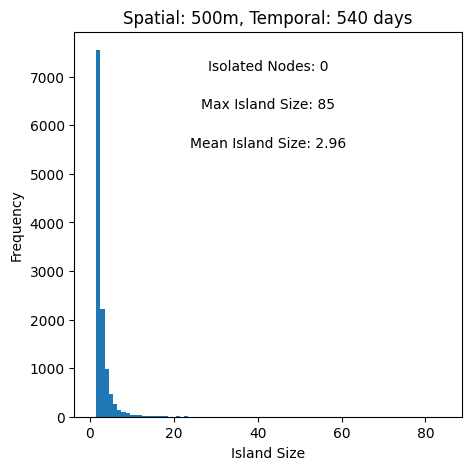

In [19]:
# spatial_threshold = 250
# temporal_threshold = 370 
spatial_threshold = 500
temporal_threshold = 180 * 3 

G = build_graph(dataset, spatial_threshold, temporal_threshold)
island_sizes, isolated_nodes = analyze_clusters(G)
results[(spatial_threshold, temporal_threshold)] = (island_sizes, isolated_nodes)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
island_sizes, isolated_nodes = results[(spatial_threshold, temporal_threshold)]

# Plot histogram
ax.hist(island_sizes, bins=range(1, max(island_sizes) + 1), align='left')
ax.set_title(f"Spatial: {spatial_threshold}m, Temporal: {temporal_threshold} days")
ax.set_xlabel('Island Size')
ax.set_ylabel('Frequency')
ax.annotate(f'Isolated Nodes: {isolated_nodes}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center')
ax.annotate(f'Max Island Size: {max(island_sizes)}', xy=(0.5, 0.8), xycoords='axes fraction', ha='center')
ax.annotate(f'Mean Island Size: {np.mean(island_sizes):.2f}', xy=(0.5, 0.7), xycoords='axes fraction', ha='center')


# Retrieve groups from clusters

In [3]:
import networkx as nx

#load graph
spatial_threshold = 1000
temporal_threshold = 365
G = nx.read_gml(f"../data/results/graph/graph_{spatial_threshold}_{temporal_threshold}.gml")

#concatenation of all datasets
import geopandas as gpd
list_dataset = [df for name, df in attribution.ddataset.items() if attribution.dtypes_[name] != 'spatial_entity']
list_spatial_entity_dataset = [df for name, df in attribution.ddataset.items() if attribution.dtypes_[name] == 'spatial_entity']

dataset = gpd.GeoDataFrame(pd.concat(list_dataset), geometry='geometry', crs=list_dataset[0].crs)[attribution.mandatory_columns + ['geometry']].reset_index().rename(columns={'index': 'id'})
dataset


,id,start_date,end_date,class,dataset,year,essence,tree_type,geometry
0,26921,2015-01-01,2015-12-31,Biotic-dieback,hm,2015.0,Pines,conifer,POINT (692250.370 6284000.121)
1,26927,2015-01-01,2015-12-31,Biotic-mortality,hm,2015.0,Pines,conifer,POINT (389232.428 6240542.909)
2,26930,2015-01-01,2015-12-31,Biotic-mortality,hm,2015.0,Pines,conifer,POINT (389297.914 6240684.432)
3,26934,2015-01-01,2015-12-31,Biotic-dieback,hm,2015.0,Pines,conifer,POINT (565569.490 6253084.860)
4,26935,2015-01-01,2015-12-31,Biotic-mortality,hm,2015.0,Pines,conifer,POINT (565563.114 6253051.639)
...,...,...,...,...,...,...,...,...,...
757489,41572,2018-09-01,2019-05-01,clear-cut,forms,NaN,deciduous oaks,None,"POLYGON ((1232620.159 6123618.901, 1232650.159..."
757490,41573,2018-09-01,2019-05-01,clear-cut,forms,NaN,None,None,"POLYGON ((1182220.159 6101878.901, 1182300.159..."
757491,41574,2018-09-01,2019-05-01,clear-cut,forms,NaN,broadleaf,Broadleaf,"POLYGON ((1189450.159 6089228.901, 1189470.159..."
757492,41575,2018-09-01,2019-05-01,clear-cut,forms,NaN,broadleaf,Broadleaf,"POLYGON ((1232930.159 6088928.901, 1232980.159..."


## Construct GeoDataFrame group from graph's islands

In [4]:
import networkx as nx
from tqdm import tqdm 

# Find the connected components (islands) in the graph
islands = list(nx.connected_components(G))

# Create a list to store the sub-GeoDataFrames
island_gdfs = []

# Iterate over each island and create a sub-GeoDataFrame
for island in tqdm(islands):
    # Select rows from the original GeoDataFrame that correspond to the current island
    island_gdf = dataset.iloc[list(island)]
    
    # Append this sub-GeoDataFrame to the list
    island_gdfs.append(island_gdf)

# Now 'island_gdfs' contains a list of GeoDataFrames, each representing an island


100%|██████████| 73616/73616 [02:50<00:00, 431.80it/s]


## Add spatial_entity datasets

In [5]:
spatial_entity_dataset = gpd.GeoDataFrame(pd.concat(list_spatial_entity_dataset), geometry='geometry', crs=list_spatial_entity_dataset[0].crs)[attribution.mandatory_columns + ['geometry']].reset_index().rename(columns={'index': 'id'})
n = dataset.index.max()
spatial_entity_dataset.index = spatial_entity_dataset.index + n + 1

In [46]:
#TODO LOC or ILOC 
import pandas as pd
from tqdm import tqdm

# Create a spatial index for the spatial_entity_dataset
spatial_entity_sindex = spatial_entity_dataset.sindex

def get_temporal_range(gdf):
    # Assuming you have a 'start_date' and 'end_date' column
    min_date = gdf['start_date'].min()
    max_date = gdf['end_date'].max()
    return min_date, max_date

for i, island_gdf in tqdm(enumerate(island_gdfs)):
    # Calculate the envelope (bounding box) of the cluster
    envelope = island_gdf.unary_union.envelope

    # Calculate the temporal range of the cluster
    cluster_start, cluster_end = get_temporal_range(island_gdf)

    # Find potential matches using spatial index
    possible_matches_index = list(spatial_entity_sindex.intersection(envelope.bounds))
    possible_matches = spatial_entity_dataset.iloc[possible_matches_index]

    if len(possible_matches_index) > 0 :
        break
    # Initialize an empty list to store events to be added
    events_to_add = []

    # Iterate through each potential match
    for event in possible_matches.itertuples(index=True):
        # Check spatial intersection
        spatial_condition = envelope.intersects(event.geometry)
        # Check temporal intersection
        event_centroid = event.centroid_date  # Replace with your actual column name
        temporal_condition = (event_centroid <= cluster_end) and (event_centroid >= cluster_start)

        # If both conditions are met, add the event to the list
        if spatial_condition and temporal_condition:
            events_to_add.append(event.Index)

    # Add the events to the cluster GeoDataFrame
    if len(events_to_add) > 0:
        additional_events = spatial_entity_dataset.loc[events_to_add]
        island_gdfs[i] = gpd.GeoDataFrame(pd.concat([island_gdf, additional_events]), geometry='geometry', crs=island_gdf.crs)

# Now each 'island_gdf' in 'island_gdfs' may have additional events from 'spatial_entity_dataset'


0it [00:00, ?it/s]


In [33]:
import pandas as pd
import geopandas as gpd

# Initialize an empty list to store the modified cluster GeoDataFrames
modified_gdfs = []

# Add a 'cluster' column and concatenate
for i, island_gdf in tqdm(enumerate(island_gdfs)):
    island_gdf['cluster'] = i  # Add a 'cluster' column with the cluster index
    modified_gdfs.append(island_gdf)


# Ensure the GeoDataFrame has the correct geometry set
all_clusters_gdf = gpd.GeoDataFrame(pd.concat(modified_gdfs), geometry='geometry').drop(columns=['year'])

# Save to GeoParquet
all_clusters_gdf.to_parquet('../data/results/clusters/clusters_geodata.parquet')


0it [00:00, ?it/s]

73616it [00:18, 4060.43it/s]


# Define intra-cluster

## clustering

In [2]:
import geopandas as gpd
all_clusters_gdf = gpd.read_parquet('../data/results/clusters/clusters_geodata.parquet')

In [3]:
groups = all_clusters_gdf.groupby('cluster')

print( f'number of groups : {len(groups)}, estimated time (4 cores) = {len(groups)/1e4 * 5} min')

number of groups : 73616, estimated time (4 cores) = 36.808 min


In [4]:
from itertools import islice
list_group = []
for name, group in islice(groups, 0, 1000):
    list_group.append(group)

In [134]:
from collections import defaultdict
from utils import get_predominant_class, compute_similarity_matrix, calculate_temporal_centroid
from typing import Callable, Dict, Tuple
from sklearn.cluster import SpectralClustering, DBSCAN
import numpy as np
import matplotlib.pyplot as plt

def get_temporal_period(cluster : gpd.GeoDataFrame, final_weighting_dict : Dict[str, dict]) -> (tuple, Tuple[pd.Timestamp, pd.Timestamp], float):

    upper_bound = 2 * 365 + abs(cluster['start_date'].min() - cluster['end_date'].max()).days
    # Determine the overall time range for the cluster
    start_date = cluster['start_date'].min() - pd.Timedelta(days=upper_bound)
    end_date = cluster['end_date'].max() + pd.Timedelta(days=upper_bound)
    time_range = pd.date_range(start=start_date, end=end_date, freq='2W')

    # Initialize an array to hold the sum of profiles
    sum_profiles = np.zeros(len(time_range))

    for event in cluster.itertuples():
        temporal_profile = final_weighting_dict[event.dataset][event._4]['temporal']
        centroid_date = calculate_temporal_centroid(event.start_date, event.end_date)

        # Days difference from each point in the time range to the centroid
        days_from_centroid = (time_range - centroid_date).days

        # Evaluate the temporal profile
        evaluated_profile = np.array([temporal_profile(abs(day)) for day in days_from_centroid])

        # Accumulate the sum
        sum_profiles += evaluated_profile

    # Average the profiles
    average_profile = sum_profiles / len(cluster)

    # Plotting
    # Assuming 'average_profile' is your array and 'time_range' is your corresponding time axis

    # Find the index of the maximum value in the average profile (peak)
    peak_index = np.argmax(average_profile)
    confidence_threshold = np.percentile(average_profile, 90)
    # Initialize variables to store the desired x-axis values
    x_val_left = None
    x_val_right = None

    # Search to the left of the peak
    for i in range(peak_index, -1, -1):  # Iterate backwards from the peak
        if average_profile[i] <= confidence_threshold:
            x_val_left = time_range[i]
            break

    # Search to the right of the peak
    for i in range(peak_index, len(average_profile)):
        if average_profile[i] <= confidence_threshold:
            x_val_right = time_range[i]
            break

    return (time_range, average_profile), (x_val_left, x_val_right), confidence_threshold

from scipy.spatial import distance   
from shapely.geometry import Polygon, MultiPolygon
from scipy.spatial import ConvexHull

def get_spatial_polygon(cluster : gpd.GeoDataFrame, final_weighting_dict: Dict[str, dict]):
    overall_centroid = cluster.geometry.centroid.unary_union.centroid
    grid_size = 30 # Adjust as needed for resolution
    minx, miny, maxx, maxy = cluster.geometry.total_bounds
    width = maxx - minx
    height = maxy - miny

    # Set half_width to be half of the larger dimension of the bounding box
    half_width = max(width, height) 
    x = np.linspace(overall_centroid.x - half_width, overall_centroid.x + half_width, grid_size)
    y = np.linspace(overall_centroid.y - half_width, overall_centroid.y + half_width, grid_size)
    xx, yy = np.meshgrid(x, y)

    # Initialize a 2D array to hold the sum of profiles
    sum_profiles = np.zeros((grid_size, grid_size))

    # Iterate through each event and accumulate its spatial profile
    for event in cluster.itertuples():
        centroid = event.geometry.centroid.coords[0]
        #plot centroid
        spatial_profile_func = final_weighting_dict[event.dataset][event._4]['spatial']

        # Calculate distances from the centroid to each point on the grid
        distances = distance.cdist([(centroid[0], centroid[1])], np.vstack([xx.ravel(), yy.ravel()]).T).reshape(grid_size, grid_size)

        # Evaluate the spatial profile for these distances
        evaluated_profile = np.array([spatial_profile_func(x) for x in np.ravel(distances)]).reshape(grid_size, grid_size)

        # Accumulate the sum
        sum_profiles += evaluated_profile

    # Average the profiles
    average_profile = sum_profiles / len(cluster)

    threshold = np.percentile(average_profile, 90)

    plt.ioff()
    contour = plt.contour(xx, yy, average_profile, levels=[threshold], colors='k', hold='on')
    plt.close()
    polygons = []
    for path in contour.collections[0].get_paths():
        vertices = path.vertices
        polygon = Polygon(vertices)
        polygons.append(polygon)

    # Combine all polygons into a MultiPolygon
    combined_polygon = MultiPolygon(polygons).simplify(10)

    return (xx, yy, average_profile),combined_polygon, threshold
    

def get_cluster(data : gpd.GeoDataFrame, dcustom_similarity_function : Dict[str, Tuple[Callable, dict, float]],
                 dtypes_: Dict[str, str], final_weighting_dict : Dict[str, dict],
                 doa : Dict[str, float], dclass_score : Dict[str, Dict[str, Dict[str, float]]], threshold=0.5) -> gpd.GeoDataFrame:
    
    """Get the cluster from a GeoDataFrame

    Args:
        data (gpd.GeoDataFrame): GeoDataFrame containing the data to be compared
        dcustom_similarity_function (Dict[str, Tuple[Callable, dict, float]]): dictionary containing the custom similarity functions, the optional arguments and the weight associated with each function
        dtypes_ (Dict[str, str]): dictionary of dataset types
        doa (Dict[str, float]): dictionary of scaling factors
        threshold (float, optional): threshold for the similarity score. Defaults to 0.5.
    
    Returns:
        gpd.GeoDataFrame: cluster
    """

    #build dclass as a dict of list containing the first attribute of the dict of dclass_sco
    similarity_matrix, _ = compute_similarity_matrix(data, dtypes_=dtypes_, dcustom_similarity_function=dcustom_similarity_function, final_weighting_dict=final_weighting_dict)

    # Perform spectral clustering
    # DBSCAN 
    dbscan = DBSCAN(eps=0.5, min_samples=1, metric='precomputed')
    labels = dbscan.fit_predict(similarity_matrix)

    # SpectralClustering
    #number of unique class,dataset - maximum number of entries of a final class among the datasets + 1
    #build dclass as a dict of list containing the first attribute of the dict of dclass_score
    # dclass = {dataset: {k: list(v.keys()) for k, v in dclass_score[dataset].items()} for dataset in dclass_score}
    # dfinal_class = {}
    # dfinal_class_datasets = defaultdict(list)
    # for i in range(1, len(data)):
    #     dataset = data.iloc[i].dataset
    #     cls = dclass[dataset][data.iloc[i]['class']]
    #     for c in cls:
    #         if dataset not in dfinal_class_datasets[c]:
    #             dfinal_class_datasets[c].append(dataset)
    #             dfinal_class[c] = dfinal_class.get(c, 0) + 1

    # uc = len(data.iloc[1:].groupby(['class', 'dataset']))
    # n_clusters = max(1, uc - max(dfinal_class.values()) + 1)

    # # Perform spectral clustering
    # sc = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans')
    # labels = sc.fit_predict(similarity_matrix)
    

    # Unique cluster labels
    data['labels'] = labels
    cluster_labels = data['labels']
    unique_labels = np.unique(cluster_labels)

    # Dictionary to hold the sum of scores and the count for each cluster
    cluster_sums = {label: {'sum': 0, 'count': 0, 'class': []} for label in unique_labels}

    # Sum scores and counts for each cluster
    for i, (score, label) in enumerate(zip(similarity_matrix[0][1:], cluster_labels)):
        ws = score * doa[data['dataset'].iloc[i+1]]
        cluster_sums[label]['sum'] += ws 
        cluster_sums[label]['count'] += 1
        cluster_sums[label]['class'].extend([(c,ws,comp) for c, comp in dclass_score[data['dataset'].iloc[i+1]][data['class'].iloc[i+1]].items()])

    # Compute average score for each cluster
    average_scores = {label: (cluster_sums[label]['sum'] / cluster_sums[label]['count']) for label in cluster_sums}
    timeperiod_group = {}
    indexes_group = {}
    threshold_group = {}
    polygons_group = {}
    data_ = data.copy()
    data_['start_date'] = pd.to_datetime(data_['start_date'], format='%Y-%m-%d')
    data_['end_date'] = pd.to_datetime(data_['end_date'], format='%Y-%m-%d')

    #get date of the median start and end date for each cluster
    for group in data_['labels'].unique():
        group_df = data_[data_['labels'] == group]
        _, (start, end), temporal_threshold = get_temporal_period(group_df, final_weighting_dict)
        _, polygon, spatial_threshold = get_spatial_polygon(group_df, final_weighting_dict)
        threshold_group[group] = (temporal_threshold, spatial_threshold)
        polygons_group[group] = polygon
        # min_start = group_df['start_date'].mean()
        # max_end = group_df['end_date'].mean()
        timeperiod_group[group] = (start, end)
        indexes_group[group] = group_df.index.tolist()



    for label in average_scores:
        average_scores[label] = (average_scores[label], get_predominant_class(cluster_sums[label]['class']), timeperiod_group[label], indexes_group[label], threshold_group[label], polygons_group[label])

    # Filter the dictionary based on similarity score > 0.5
    filtered_d = {k: v for k, v in average_scores.items() if v[0] > threshold}

    # Convert the filtered dictionary into a DataFrame
    df = pd.DataFrame.from_dict(filtered_d, orient='index', columns=['IntraSimilarity', 'Class', 'TimePeriod', 'Indexes', 'Threshold', 'geometry'])

    # Ensure the dates are in the correct format (if they are strings)
    df['Start_Date'], df['End_Date'] = zip(*df['TimePeriod'])
    df['Temporal_threshold'], df['Spatial_threshold'] = zip(*df['Threshold'])
    df = df.drop(['TimePeriod', 'Threshold'], axis=1)

    # Convert the string dates to datetime objects if needed
    df['Start_Date'] = pd.to_datetime(df['Start_Date'], dayfirst=True)
    df['End_Date'] = pd.to_datetime(df['End_Date'], dayfirst=True)

    return gpd.GeoDataFrame(df.sort_values(by='IntraSimilarity', ascending=False), geometry='geometry', crs=data.crs)


def wrapper_get_cluster(data: gpd.GeoDataFrame, dtypes_, dcustom_similarity_function, doa, dclass_score, final_weighting_dict, threshold):
    """Wrapper function for get_cluster"""

    if len(data) == 1:
        return pd.DataFrame({'Similarity':[0.], 'Class':['Unknown'], 'Start_Date':[data.iloc[0].start_date], 'End_Date':[data.iloc[0].end_date], 'index_reference':[data.iloc[0].index_reference]})
    else:
        return get_cluster(data, dtypes_=dtypes_, dcustom_similarity_function=dcustom_similarity_function, doa=doa, dclass_score=dclass_score, final_weighting_dict=final_weighting_dict, threshold=threshold)


spectral clustering -> 139ms
dbscan -> 78.8 ms 

In [137]:
%%time

from utils import compute_tree_coherence, compute_class_similarity
from constants import DCLASS_SCORE
dcustom_similarity_function = {'tree specie relatedness': (compute_tree_coherence, {}, 1.0), 'class relatedness': (compute_class_similarity, {'dclass_score': DCLASS_SCORE}, 1.0)}
index = 29
group = list_group[index]
print(len(group))
a = wrapper_get_cluster(group, dtypes_=dtypes, dcustom_similarity_function=dcustom_similarity_function, doa=doa, dclass_score=DCLASS_SCORE, final_weighting_dict=attribution.final_weighting_dict, threshold=0.)
group

32
[('biotic-dieback', {'count': 31, 'comp_similarity_sum': 2.0656871543971063, 'average_composed_similarity': 0.06663506949668084}), ('fire', {'count': 30, 'comp_similarity_sum': 11.092001698229119, 'average_composed_similarity': 0.3697333899409706}), ('anthropogenic', {'count': 30, 'comp_similarity_sum': 3.828134830929732, 'average_composed_similarity': 0.1276044943643244}), ('storm', {'count': 30, 'comp_similarity_sum': 2.1620800195308223, 'average_composed_similarity': 0.07206933398436075}), ('drought-dieback', {'count': 30, 'comp_similarity_sum': 1.2057797606329148, 'average_composed_similarity': 0.040192658687763824}), ('biotic-mortality', {'count': 12, 'comp_similarity_sum': 1.0810282023972508, 'average_composed_similarity': 0.09008568353310424})]
CPU times: user 1.32 s, sys: 14.8 ms, total: 1.34 s
Wall time: 1.36 s


,id,start_date,end_date,class,dataset,essence,tree_type,geometry,cluster,labels
164568,555747,2015-01-01,2015-12-31,Other,senfseidl,"broadleaf,evergreen oaks,maritime pine",Mixed,"POLYGON ((755898.038 6338911.025, 755868.210 6...",29,-1
704845,5466279,2015-01-01,2015-12-31,Fire,senfseidl,"evergreen oaks,broadleaf,mixed,chestnut,mariti...",Mixed,"POLYGON ((756749.805 6339141.559, 756869.114 6...",29,-1
704851,5466286,2015-01-01,2015-12-31,Fire,senfseidl,maritime pine,Conifer,"POLYGON ((756180.440 6339118.452, 756150.613 6...",29,-1
704839,5466273,2015-01-01,2015-12-31,Fire,senfseidl,"broadleaf,maritime pine,evergreen oaks",Mixed,"POLYGON ((757136.831 6338845.931, 757166.658 6...",29,-1
164567,555746,2015-01-01,2015-12-31,Other,senfseidl,"broadleaf,maritime pine,mixed,evergreen oaks",Mixed,"POLYGON ((757438.478 6339175.825, 757408.651 6...",29,-1
164572,555751,2015-01-01,2015-12-31,Other,senfseidl,"evergreen oaks,mixed",Mixed,"POLYGON ((756425.079 6339412.846, 756454.906 6...",29,-1
704843,5466277,2015-01-01,2015-12-31,Fire,senfseidl,"broadleaf,maritime pine",Mixed,"POLYGON ((757364.868 6338987.935, 757394.695 6...",29,-1
704848,5466283,2015-01-01,2015-12-31,Fire,senfseidl,"broadleaf,evergreen oaks,maritime pine",Mixed,"POLYGON ((755911.994 6339093.334, 755882.166 6...",29,-1
164564,555743,2015-01-01,2015-12-31,Other,senfseidl,"broadleaf,maritime pine,evergreen oaks",Mixed,"POLYGON ((757293.903 6338770.124, 757353.557 6...",29,-1
704841,5466275,2015-01-01,2015-12-31,Fire,senfseidl,"broadleaf,mixed",Mixed,"POLYGON ((756632.411 6338768.569, 756572.756 6...",29,-1


In [138]:
a

,IntraSimilarity,Class,Indexes,geometry,Start_Date,End_Date,Temporal_threshold,Spatial_threshold
-1,0.691442,biotic-dieback,"[164568, 704845, 704851, 704839, 164567, 16457...","POLYGON ((756499.600 6338446.070, 756905.690 6...",2015-02-15,2015-11-22,0.987344,0.222765


<Axes: >

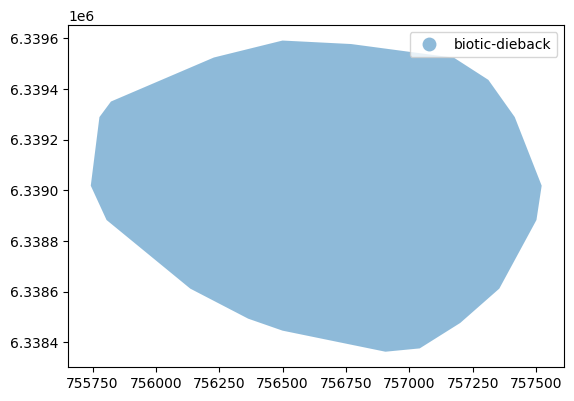

In [139]:
plt.ion()
a.plot(column='Class', legend=True, alpha=0.5)

## Define temporal extent

In [118]:
cluster = all_clusters_gdf.loc[a.iloc[0].Indexes]
cluster 

,id,start_date,end_date,class,dataset,essence,tree_type,geometry,cluster
704845,5466279,2015-01-01,2015-12-31,Fire,senfseidl,"evergreen oaks,broadleaf,mixed,chestnut,mariti...",Mixed,"POLYGON ((756749.805 6339141.559, 756869.114 6...",29
704839,5466273,2015-01-01,2015-12-31,Fire,senfseidl,"broadleaf,maritime pine,evergreen oaks",Mixed,"POLYGON ((757136.831 6338845.931, 757166.658 6...",29
164567,555746,2015-01-01,2015-12-31,Other,senfseidl,"broadleaf,maritime pine,mixed,evergreen oaks",Mixed,"POLYGON ((757438.478 6339175.825, 757408.651 6...",29
164572,555751,2015-01-01,2015-12-31,Other,senfseidl,"evergreen oaks,mixed",Mixed,"POLYGON ((756425.079 6339412.846, 756454.906 6...",29
704843,5466277,2015-01-01,2015-12-31,Fire,senfseidl,"broadleaf,maritime pine",Mixed,"POLYGON ((757364.868 6338987.935, 757394.695 6...",29
704841,5466275,2015-01-01,2015-12-31,Fire,senfseidl,"broadleaf,mixed",Mixed,"POLYGON ((756632.411 6338768.569, 756572.756 6...",29
704840,5466274,2015-01-01,2015-12-31,Fire,senfseidl,"evergreen oaks,mixed,broadleaf",Mixed,"POLYGON ((756667.529 6338711.520, 756697.356 6...",29
164565,555744,2015-01-01,2015-12-31,Other,senfseidl,"mixed,broadleaf",Mixed,"POLYGON ((756619.185 6338918.167, 756708.667 6...",29
704849,5466284,2015-01-01,2015-12-31,Fire,senfseidl,"broadleaf,evergreen oaks,maritime pine,mixed",Mixed,"POLYGON ((756389.232 6339137.989, 756419.059 6...",29
704856,5466291,2015-01-01,2015-12-31,Fire,senfseidl,mixed,Mixed,"POLYGON ((757119.043 6339387.276, 757089.216 6...",29


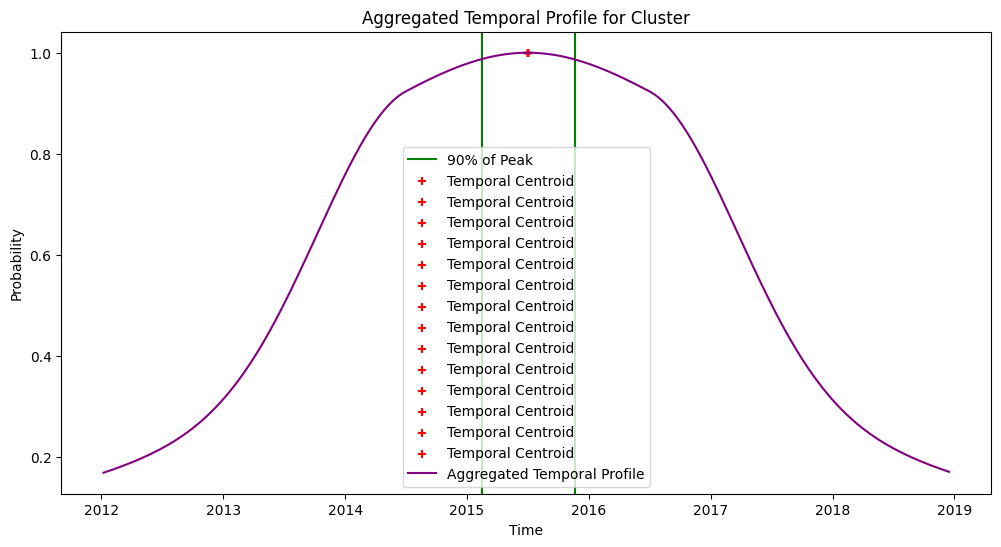

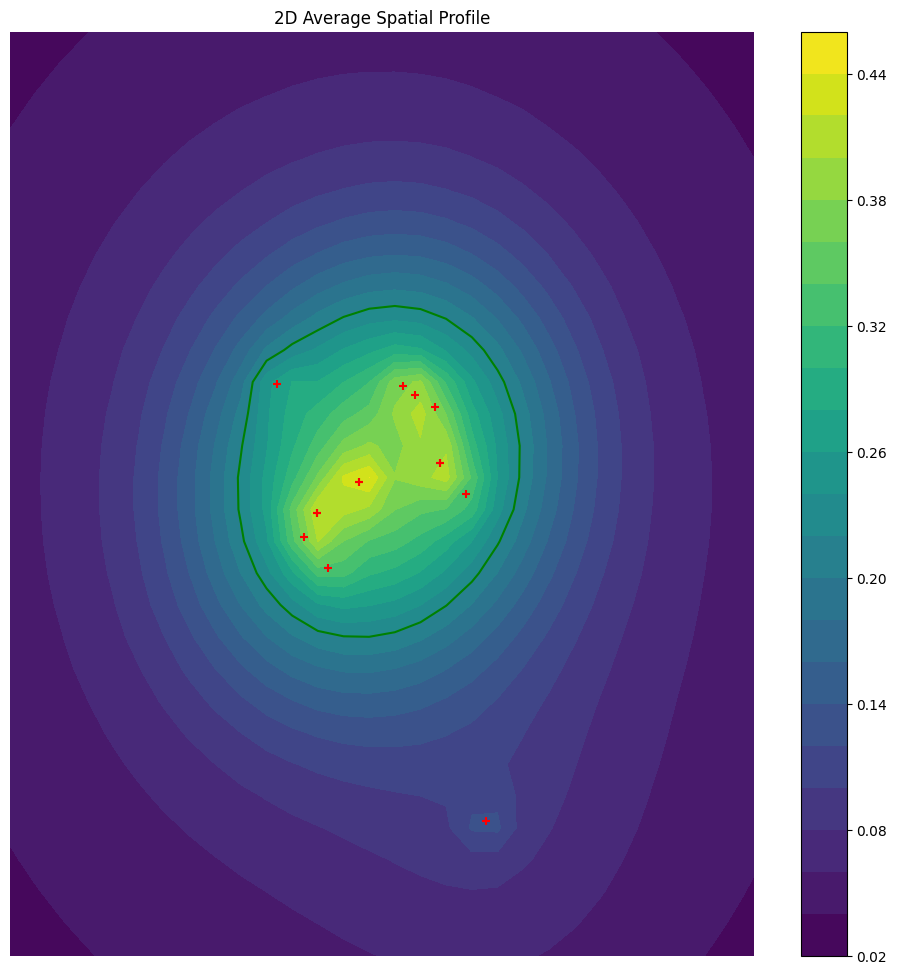

CPU times: user 1.42 s, sys: 133 ms, total: 1.56 s
Wall time: 1.14 s


In [108]:
%%time

(time_range, average_profile), (x_val_left, x_val_right), confidence_threshold = get_temporal_period(cluster, attribution.final_weighting_dict)
plt.figure(figsize=(12, 6))
plt.axvline(x=x_val_left, color='green', label="90% of Peak")
plt.axvline(x=x_val_right, color='green')
for event in cluster.itertuples():
    centroid_date = calculate_temporal_centroid(event.start_date, event.end_date)
    plt.scatter([centroid_date], [attribution.final_weighting_dict[event.dataset][event._4]['temporal'](0)], color='red', label="Temporal Centroid", marker='+')
plt.plot(time_range, average_profile, label="Aggregated Temporal Profile", color='purple')
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Aggregated Temporal Profile for Cluster")
plt.legend()
plt.show()

(xx, yy, average_profile), polygon, threshold = get_spatial_polygon(cluster, attribution.final_weighting_dict)
plt.figure(figsize=(12, 12))
CS = plt.contourf(xx, yy, average_profile, levels=20)
CS2 = plt.contour(CS, levels=[threshold], colors='g')
plt.colorbar(CS)
plt.scatter(cluster.geometry.centroid.x, cluster.geometry.centroid.y, color='red', label="Spatial Centroid", marker='+')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Average Spatial Profile')
#remove axis
plt.gca().set_axis_off()
plt.show()



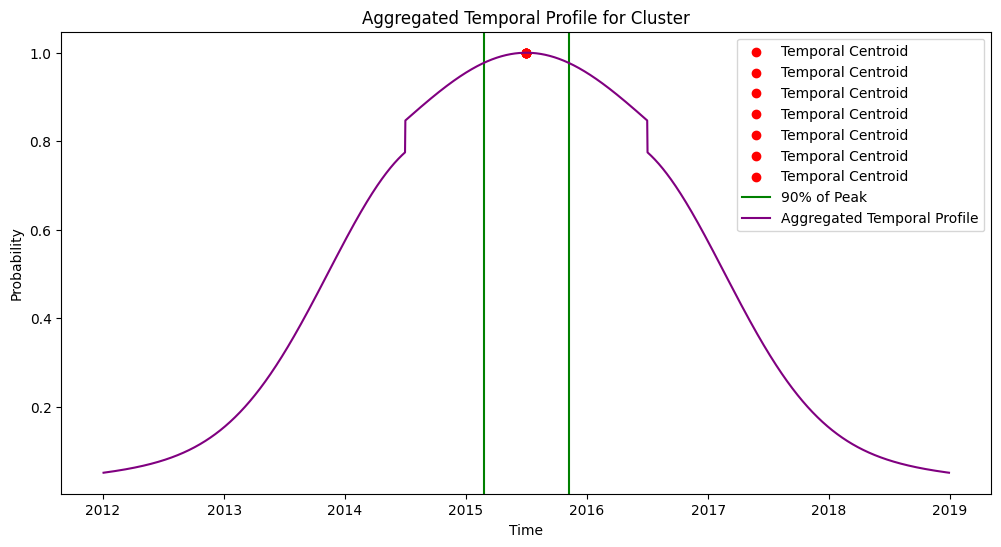

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import calculate_temporal_centroid

upper_bound = 2 * 365 + abs(cluster['start_date'].min() - cluster['end_date'].max()).days

# Determine the overall time range for the cluster
start_date = cluster['start_date'].min() - pd.Timedelta(days=upper_bound)
end_date = cluster['end_date'].max() + pd.Timedelta(days=upper_bound)
time_range = pd.date_range(start=start_date, end=end_date)

# Initialize an array to hold the sum of profiles
sum_profiles = np.zeros(len(time_range))
plt.figure(figsize=(12, 6))
# Shift and evaluate each profile
for event in cluster.itertuples():
    temporal_profile = attribution.final_weighting_dict[event.dataset][event._4]['temporal']
    centroid_date = calculate_temporal_centroid(event.start_date, event.end_date)
    plt.scatter([centroid_date], [temporal_profile(0)], color='red', label="Temporal Centroid")

    # Days difference from each point in the time range to the centroid
    days_from_centroid = (time_range - centroid_date).days

    # Evaluate the temporal profile
    evaluated_profile = np.array([temporal_profile(abs(day)) for day in days_from_centroid])

    # Accumulate the sum
    sum_profiles += evaluated_profile

# Average the profiles
average_profile = sum_profiles / len(cluster)

# Plotting
# Assuming 'average_profile' is your array and 'time_range' is your corresponding time axis

# Find the index of the maximum value in the average profile (peak)
peak_index = np.argmax(average_profile)

# Initialize variables to store the desired x-axis values
x_val_left = None
x_val_right = None

threshold = np.percentile(average_profile, 90)
# Search to the left of the peak
for i in range(peak_index, -1, -1):  # Iterate backwards from the peak
    if average_profile[i] <= threshold:
        x_val_left = time_range[i]
        break

# Search to the right of the peak
for i in range(peak_index, len(average_profile)):
    if average_profile[i] <= threshold:
        x_val_right = time_range[i]
        break

plt.axvline(x=x_val_left, color='green', label="90% of Peak")
plt.axvline(x=x_val_right, color='green')
plt.plot(time_range, average_profile, label="Aggregated Temporal Profile", color='purple')
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Aggregated Temporal Profile for Cluster")
plt.legend()
plt.show()


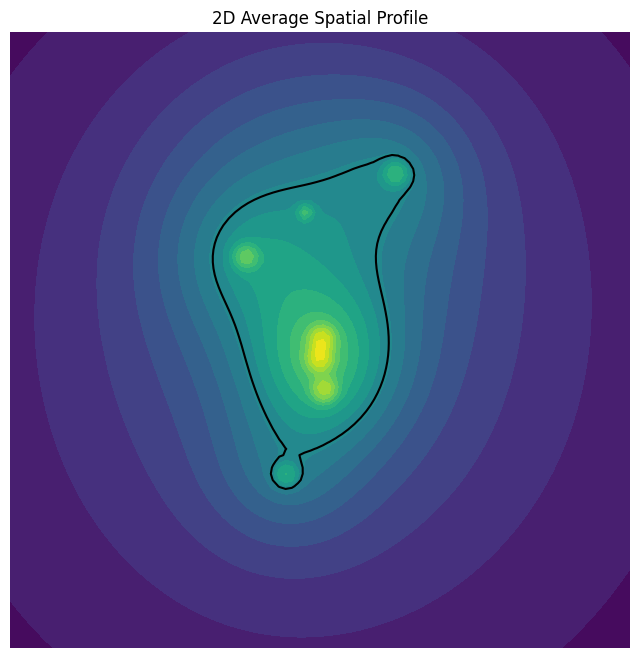

In [85]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import distance

def get_overall_centroid(cluster):
    # Combine all geometries into a single MultiPoint
    combined = cluster.geometry.unary_union
    # Return the centroid of the combined geometries
    return combined.centroid

overall_centroid = get_overall_centroid(cluster)
grid_size = 100 # Adjust as needed for resolution
minx, miny, maxx, maxy = cluster.geometry.total_bounds
width = maxx - minx
height = maxy - miny

# Set half_width to be half of the larger dimension of the bounding box
half_width = max(width, height) 
x = np.linspace(overall_centroid.x - half_width, overall_centroid.x + half_width, grid_size)
y = np.linspace(overall_centroid.y - half_width, overall_centroid.y + half_width, grid_size)
xx, yy = np.meshgrid(x, y)


# Initialize a 2D array to hold the sum of profiles
sum_profiles = np.zeros((grid_size, grid_size))

# Iterate through each event and accumulate its spatial profile
plt.figure(figsize=(8, 8))
for event in cluster.itertuples():
    centroid = event.geometry.centroid.coords[0]
    #plot centroid
    plt.scatter([centroid[0]], [centroid[1]], color='red', label="Spatial Centroid")
    spatial_profile_func = attribution.final_weighting_dict[event.dataset][event._4]['spatial']

    # Calculate distances from the centroid to each point on the grid
    distances = distance.cdist([(centroid[0], centroid[1])], np.vstack([xx.ravel(), yy.ravel()]).T).reshape(grid_size, grid_size)

    # Evaluate the spatial profile for these distances
    evaluated_profile = np.array([spatial_profile_func(x) for x in np.ravel(distances)]).reshape(grid_size, grid_size)

    # Accumulate the sum
    sum_profiles += evaluated_profile

# Average the profiles
average_profile = sum_profiles / len(cluster)

# Plotting the average spatial profile
threshold = np.percentile(average_profile, 90)
CS = plt.contourf(xx, yy, average_profile, levels=20, cmap='viridis')
CS2 = plt.contour(CS, levels=[threshold], colors='k', hold='on')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('2D Average Spatial Profile')
#remove axis
plt.gca().set_axis_off()
plt.show()



In [44]:
max(average_profile.flatten())

0.12820926577031472

In [76]:
half_width

147680.61063557863

In [31]:
from shapely.geometry import Polygon

path = CS2.collections[0].get_paths()[0]
vertices = path.vertices
polygone_09 = Polygon(vertices).simplify(10)

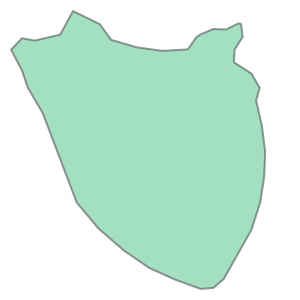

In [32]:
polygone_09